In [1]:
# Import of the required libraries
import pandas as pd
import datetime as datetime
from datetime import datetime as dtt
import folium

# Import of the software's modules
import codepos.RINEXreader as rr
import codepos.easyPlot as ep
import codepos.functions as fn
import codepos.pointPositioning as pp
import codepos.transformations as trf
from NQ import TEC as modTEC
from NQ import modelParams as mp

In [2]:
# Definition of the paths to the RINEX files stored locally
nav_path = 'C:/git/pointPositioning/pointPositioning/testRINEX/mose_nav.rnx'
obs_path = 'C:/git/pointPositioning/pointPositioning/testRINEX/mose_obs.crx'
eph_path = 'C:/git/pointPositioning/pointPositioning/testRINEX/EPH_2021_5_6.SP3'

In [3]:
# Definition of the time range in
time_range = []
START = dtt.strptime('2021-05-06 00:00:00', '%Y-%m-%d %H:%M:%S')
END = dtt.strptime('2021-05-06 23:45:00', '%Y-%m-%d %H:%M:%S')
t = START
while t <= END:
    time_range.append(t)
    t = t + datetime.timedelta(minutes=5)

# Orbit computation

In [4]:
# Get the orbits of a specific constellation starting from raw data, the DataFrames containing the orbits are locally stored
# to retrieve them easier since computing the orbits is a time-consuming function for long time ranges
'''
sat_galileo = fn.getGALILEOorbits(nav_path, obs_path, time_range)
sat_galileo.to_csv('C:/git/pointPositioning/pointPositioning/csv/sat_galileo.csv')
sat_gps = fn.getGPSorbits(nav_path, obs_path, time_range)
sat_gps.to_csv('C:/git/pointPositioning/pointPositioning/csv/sat_gps.csv')
satellites = pd.concat([sat_gps, sat_galileo])
satellites.to_csv('C:/git/pointPositioning/pointPositioning/csv/satellites.csv')
'''

sat_galileo = trf.fixDateTime(pd.read_csv('C:/git/pointPositioning/pointPositioning/csv/orbite/sat_galileo.csv'))
sat_gps = trf.fixDateTime(pd.read_csv('C:/git/pointPositioning/pointPositioning/csv/orbite/sat_gps.csv'))
satellites = trf.fixDateTime(pd.read_csv('C:/git/pointPositioning/pointPositioning/csv/orbite/satellites.csv'))


In [ ]:
# Check on satellites orbits and clock offsets:
check_pos_gal = fn.checkSatPos(sat_galileo, eph_path)
check_pos_gps = fn.checkSatPos(sat_gps, eph_path)

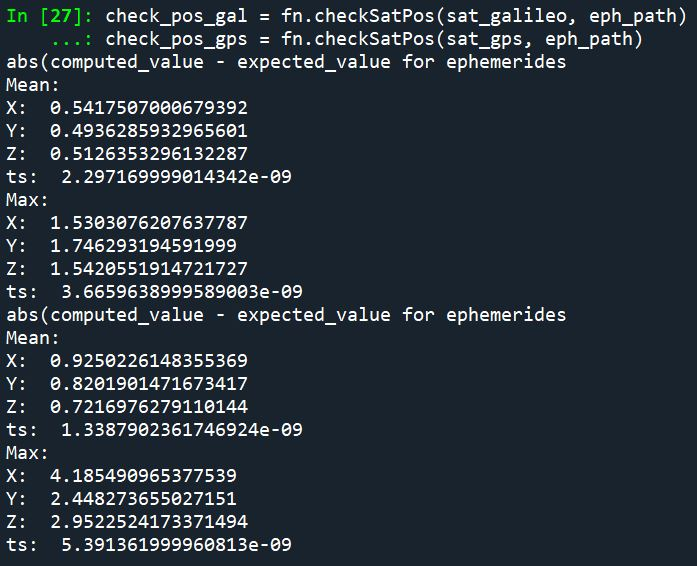

In [5]:
'''
As example the trajectory of the GPS satellite G01 is shown, for the time interval 
in which it is visible from M0SE PS during the whole day of analysis (elevation> cutoff)
'''

M0SE_cart = [4642432.701789316, 1028629.1051167124, 4236854.058403561]
M0SE_geod = trf.cartToGeod(4642432.701789316, 1028629.1051167124, 4236854.058403561)

G1 = sat_gps[sat_gps['sv'] == 'G01'].reset_index().drop(columns=['index'])
m = folium.Map(location=[M0SE_geod[0], M0SE_geod[1]], zoom_start=3)

for i in range(len(G1)):
    temp = trf.cartToGeod(G1['xs'][i], G1['ys'][i], G1['zs'][i])
    folium.Circle(
        location=(temp[0], temp[1]),
        radius=50,
        fill=True,
        color = 'red',
        fill_opacity=1
    ).add_to(m)
    
folium.Circle(
        location=(M0SE_geod[0], M0SE_geod[1]),
        radius=100,
        fill=True,
        color = 'blue',
        fill_opacity=1
    ).add_to(m)

m
#m.save('map.html')

# Point Positioning

In [6]:
'''
With the function pointPositioning we are going to estimate the position of the receiver by using GPS and Galileo code obs.

UKNOWN OF THE SYSTEM: [xr, yr, zr, tr_GPS, tr_GAL]
      
Ionospheric delay:
   - computed with Klobuchar model for GPS
   - computed with NeQuickG algorithm for Galileo

Tropospheric delay: computed with Saastamoinen model
'''

cutoff = 5
results = pp.pointPositioning2(satellites, nav_path, obs_path, cutoff)

In [7]:
'''
The estimated positions of the receiver are converted in Local Cartesian with respect the precise position of the receiver
'''
results_LC = trf.GCtoLC(M0SE_cart, results)

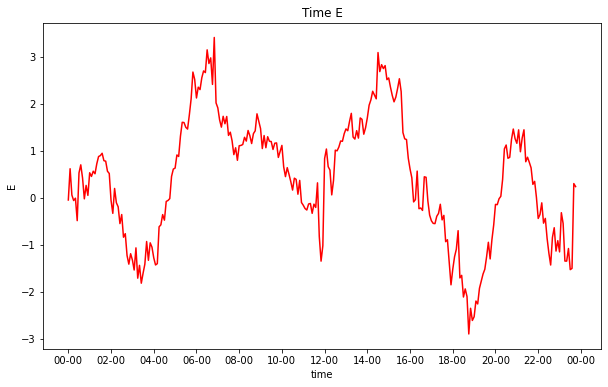

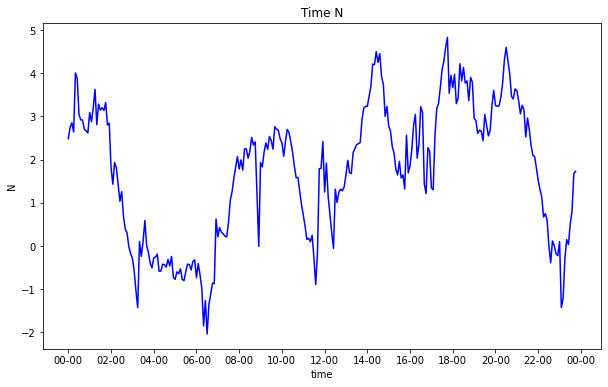

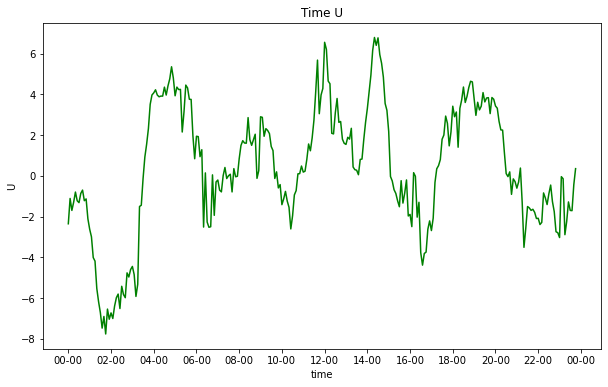

In [8]:
# Plot of the results
ep.getPlot(results_LC, 'time', 'E', 'red')
ep.getPlot(results_LC, 'time', 'N', 'blue')
ep.getPlot(results_LC, 'time', 'U', 'green')

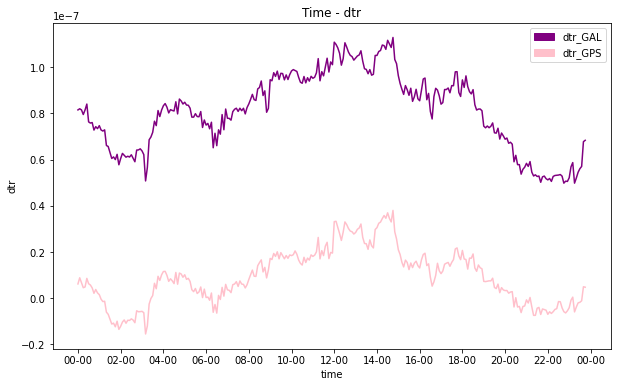

In [9]:
ep.getTimePlot(results, 'datetime', 'dtr_GPS', 'dtr_GAL')

# Focus on NeQuickG algorithm

In [10]:
'''
Thanks to modelParams module (contained in NQ folder) it is possible to evaluate the atmospheric parameters 
required to compute the ionospheric delay for Galileo observations. The parameters are time and location dependant.
As example, we show the parameters for:
    - time: 2021-05-06 12:00:00
    - location: M0SE PS
'''

time = dtt.strptime('2021-05-06 12:00:00', '%Y-%m-%d %H:%M:%S')

parametri = mp.getModelParams(M0SE_geod[0], M0SE_geod[1], time, nav_path)

parametri

{'foE': 3.131812187734728,
 'NmE': 1.2162226998262289,
 'foF1': 4.384537062828619,
 'NmF1': 2.3837964916594085,
 'foF2': 4.1038862467497434,
 'NmF2': 2.0883934084564504,
 'M_3000': 3.3182914037940403,
 'hmE': 120,
 'hmF1': 169.939531923874,
 'hmF2': 219.879063847748,
 'B2bot': 20.30990579154562,
 'B1top': 14.981859577162199,
 'B1bot': 24.969765961937,
 'BEtop': 24.969765961937,
 'BEbot': 5,
 'A1': 8.353573633825802,
 'A2': 6.206141026201111,
 'A3': 2.017564044381239,
 'H0': 63.90052731997999}

Slant TEC algorithm used
n:  8
n:  16
n:  8
n:  16
n:  8
n:  16
Slant TEC algorithm used
n:  8
n:  16
n:  8
n:  16
n:  8
n:  16
Slant TEC algorithm used
n:  8
n:  16
n:  8
n:  16
n:  8
n:  16
Slant TEC algorithm used
n:  8
n:  16
n:  8
n:  16
n:  8
n:  16
Slant TEC algorithm used
n:  8
n:  16
n:  8
n:  16
n:  8
n:  16
Slant TEC algorithm used
n:  8
n:  16
n:  8
n:  16
n:  8
n:  16


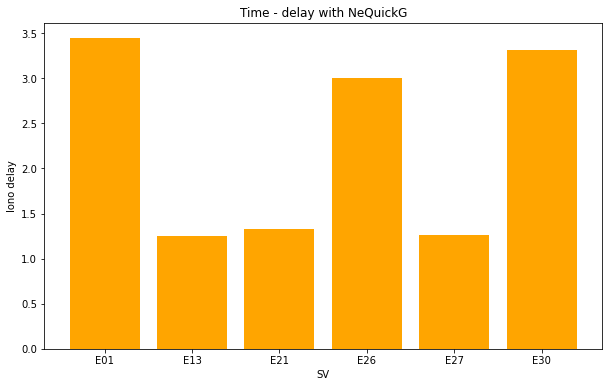

In [20]:
'''
Knowing the position of the satellites in view, it is possible to compute the ionospheric delay for each Galileo satellite
'''

sat_gal_12 = sat_galileo[sat_galileo['time'] == time].reset_index().drop(columns=['index'])

P1 = M0SE_geod
P1[2] = P1[2]*10**(-3)

delay = []
for i in range(len(sat_gal_12)):
    PS = trf.cartToGeod(sat_gal_12['xs'][i], sat_gal_12['ys'][i], sat_gal_12['zs'][i])
    PS[2] = PS[2]*10**(-3)
    d = modTEC.getTEC(P1, PS, parametri)
    delay.append(d*40.3*10**16/(1575.42*10**6)**2)

sat_gal_12['iono_delay'] = delay

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))
ax.bar(sat_gal_12['sv'], sat_gal_12['iono_delay'], color='orange')
ax.set(xlabel='SV', ylabel='Iono delay', title = 'Time - delay with NeQuickG')
plt.show()

In [42]:
grid = pd.DataFrame(columns=['lat', 'lon', 'vTEC'])

for i in range(-80, 90, 10):
    for j in range(-170, 180, 10):
        par = mp.getModelParams(i, j, time, nav_path)
        vTEC = modTEC.verticalTEC(50, 1000, 0.01, par)
        new_row = pd.DataFrame([[i, j, vTEC]], columns=['lat', 'lon', 'vTEC'])
        grid = grid.append(new_row)

In [61]:
import branca.colormap as cm

grid = grid.dropna().reset_index().drop(columns=['index'])
m = folium.Map(location=[0, 0], zoom_start=1)
cmap = cm.LinearColormap(colors=['yellow','green', 'red', 'blue'], 
                         vmin=grid['vTEC'].min(), vmax=grid['vTEC'].max(), 
                         caption='Vertical TEC (50:1000 km)')


In [64]:
lat = list(grid.lat)
lon = list(grid.lon)
v = list(grid.vTEC)
for loc, p in zip(zip(lat, lon), v):
    folium.CircleMarker(
        location=loc,
        radius=5,
        fill=True,
        color=cmap(p),
        fill_opacity=0.7
    ).add_to(m)
m.add_child(cmap)
m